In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

Leer datos

In [2]:
customers = pd.read_csv("customers.csv")
sales = pd.read_csv("sales.csv")
weekly_weather = pd.read_pickle("weather_groupby.pkl")
weather_clusters = pd.read_pickle("clusters_agglomerative.pkl")

Especificar productos de interés

In [3]:
prods = [
    "COLAS REGULAR FAMILIAR RETORNABLE",
    "COLAS REGULAR FAMILIAR NO RETORNABLE",
    "SABORES FAMILIAR RETORNABLE",
    "SABORES FAMILIAR NO RETORNABLE"
]

sales = sales[sales["prod_key"].isin(prods)]

Tomar los subcanales de los clientes

In [4]:
subchannels = customers[["customer_id", "comercial_subchannel_d"]]

Filtrar ventas de los top subcanales

In [5]:
# Merge de ventas con sus respectivos subcanales de acuerdo al cliente
sales_subchannels = sales.merge(subchannels, on="customer_id", how="left")

# Obtener los 4 subcanales con mayores ventas
sales_by_subchannel = sales_subchannels.groupby("comercial_subchannel_d")["sold"].sum().reset_index().sort_values(by="sold", ascending=False)
top4_subchannels = sales_by_subchannel.sort_values(by="sold", ascending=False).head(4)["comercial_subchannel_d"].tolist()

# Filtrar las ventas para que solo contengan los 4 subcanales con mayores ventas
customers_top4 = customers[customers["comercial_subchannel_d"].isin(top4_subchannels)]
sales_top4 = sales.merge(customers_top4[["customer_id", "comercial_subchannel_d"]], on="customer_id", how="inner")
sales_top4

,customer_id,prod_key,week,prediction,sold,comercial_subchannel_d
0,c93884c4c397a219a0fcb0061e15ced3359f7270294266...,COLAS REGULAR FAMILIAR NO RETORNABLE,202427,0.00,0.00,Abarrotes / Almacenes / Bodegas / Víveres
1,c93884c4c397a219a0fcb0061e15ced3359f7270294266...,SABORES FAMILIAR NO RETORNABLE,202440,0.88,3.52,Abarrotes / Almacenes / Bodegas / Víveres
2,c93884c4c397a219a0fcb0061e15ced3359f7270294266...,SABORES FAMILIAR RETORNABLE,202452,0.00,0.00,Abarrotes / Almacenes / Bodegas / Víveres
3,3115945bebb64d75821d8bc73777f3cdf3eede6c1352d6...,SABORES FAMILIAR RETORNABLE,202450,0.00,0.00,Estanquillos / kioscos
4,e04adcef4fba36fb00de00aab19bed307559265ebd917a...,COLAS REGULAR FAMILIAR RETORNABLE,202402,36.63,38.04,Estanquillos / kioscos
...,...,...,...,...,...,...
354635,59dc5e415352557a3742e469ed22c6ec95c5542f1d8a1b...,SABORES FAMILIAR NO RETORNABLE,202427,0.00,0.00,Abarrotes / Almacenes / Bodegas / Víveres
354636,648454febac3d78a467ca420b9683e909a1a2f3d2f5a92...,COLAS REGULAR FAMILIAR NO RETORNABLE,202404,5.28,20.43,Hogar con Venta
354637,648454febac3d78a467ca420b9683e909a1a2f3d2f5a92...,COLAS REGULAR FAMILIAR RETORNABLE,202448,27.47,20.78,Hogar con Venta
354638,92d6452328950102e9be4756f46982fc88e02fd9549d7e...,SABORES FAMILIAR NO RETORNABLE,202427,0.00,0.00,Hogar con Venta


Hacer pivot de las ventas

In [6]:
# Crear un diccionario que mapee cada prod_key a sus iniciales
prod_iniciales = {
    p: ''.join([palabra[0].upper() for palabra in p.split()])
    for p in sales_top4["prod_key"].unique()
}

# Pivot
sales_pivot = sales_top4.pivot_table(
    index=["customer_id", "week"],
    columns="prod_key",
    values=["prediction", "sold"]
)

# Renombrar columnas con iniciales
sales_pivot.columns = [
    f"{metric}_{prod_iniciales[product]}"
    for metric, product in sales_pivot.columns
]

sales_pivot = sales_pivot.reset_index()
sales_pivot

,customer_id,week,prediction_CRFNR,prediction_CRFR,prediction_SFNR,prediction_SFR,sold_CRFNR,sold_CRFR,sold_SFNR,sold_SFR
0,004a92cf90a4405fa13b3b48deb9855c6dd957ee7ddb9b...,202401,6.34,7.75,1.32,0.0,5.28,7.40,0.00,0.00
1,004a92cf90a4405fa13b3b48deb9855c6dd957ee7ddb9b...,202402,6.34,5.64,0.00,0.0,10.70,14.79,2.95,0.00
2,004a92cf90a4405fa13b3b48deb9855c6dd957ee7ddb9b...,202403,3.17,6.87,0.00,0.0,5.28,7.40,6.34,0.00
3,004a92cf90a4405fa13b3b48deb9855c6dd957ee7ddb9b...,202404,5.28,4.23,0.00,0.0,5.99,10.92,0.00,0.00
4,004a92cf90a4405fa13b3b48deb9855c6dd957ee7ddb9b...,202405,3.17,7.75,0.00,0.0,5.99,9.86,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
88655,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202448,16.56,8.81,0.00,0.0,15.15,3.17,0.00,0.00
88656,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202449,16.56,9.86,0.00,0.0,25.01,9.86,0.00,2.11
88657,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202450,17.61,9.86,0.00,0.0,21.49,3.17,13.03,0.00
88658,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202451,21.13,9.86,0.00,0.0,16.91,13.39,0.00,0.00


Convertir datos de temperatura a Celsius

In [7]:
temp_cols = ["highest_temp", "lowest_temp", "avg_daily_all_hours", "avg_daily_max_min", "extreme_highest"]

weekly_weather[temp_cols] = (weekly_weather[temp_cols]  - 32) * 5/9

Agregar la estación a los datos de clima

In [8]:
weekly_weather = weather_clusters.merge(weekly_weather, on="weather_station_id", how="left")
weekly_weather["week"] = weekly_weather["week"].astype(int)
weekly_weather

,weather_station_id,cluster,week,highest_temp,lowest_temp,avg_daily_all_hours,avg_daily_max_min,extreme_highest,hdd_max_min,hdd_all_hours,cdd_max_min,cdd_all_hours,precipitation
0,004784ca59d476279540ee2fb4f01b1521c38a3cd643cc...,0,202401,23.412698,6.428571,14.841270,14.920635,30.634921,6.142857,6.285714,0.000000,0.000000,0.011429
1,004784ca59d476279540ee2fb4f01b1521c38a3cd643cc...,0,202402,25.000000,6.904762,15.317460,16.031746,31.190476,4.428571,5.428571,0.000000,0.000000,0.000000
2,004784ca59d476279540ee2fb4f01b1521c38a3cd643cc...,0,202403,26.269841,9.047619,16.904762,17.619048,30.714286,1.571429,2.571429,0.428571,0.000000,0.002857
3,004784ca59d476279540ee2fb4f01b1521c38a3cd643cc...,0,202404,26.666667,7.619048,17.142857,17.301587,32.460317,2.428571,2.142857,0.000000,0.000000,0.000000
4,004784ca59d476279540ee2fb4f01b1521c38a3cd643cc...,0,202405,25.634921,9.603175,17.380952,17.539683,32.301587,2.142857,2.142857,0.857143,0.428571,0.008571
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1711,fd15fbdb96badcc3a102ee0c538601adbe23dfe42511f8...,0,202448,29.603175,6.111111,17.301587,17.857143,28.968254,1.285714,1.857143,0.000000,0.000000,0.000000
1712,fd15fbdb96badcc3a102ee0c538601adbe23dfe42511f8...,0,202449,25.952381,7.857143,16.428571,16.904762,28.253968,2.857143,3.428571,0.142857,0.000000,0.000000
1713,fd15fbdb96badcc3a102ee0c538601adbe23dfe42511f8...,0,202450,26.904762,6.507937,16.269841,16.746032,28.571429,3.000000,3.714286,0.000000,0.000000,0.000000
1714,fd15fbdb96badcc3a102ee0c538601adbe23dfe42511f8...,0,202451,24.682540,5.952381,14.603175,15.317460,27.777778,5.571429,6.714286,0.000000,0.000000,0.001429


Agregar la estación a los datos de ventas

In [9]:
stations = customers[["customer_id", "weather_station_id"]]
sales_pivot = sales_pivot.merge(stations, on="customer_id", how="left")
sales_pivot

,customer_id,week,prediction_CRFNR,prediction_CRFR,prediction_SFNR,prediction_SFR,sold_CRFNR,sold_CRFR,sold_SFNR,sold_SFR,weather_station_id
0,004a92cf90a4405fa13b3b48deb9855c6dd957ee7ddb9b...,202401,6.34,7.75,1.32,0.0,5.28,7.40,0.00,0.00,ba5f6ceebdb0e625388424a471b3f46291d04bf1987995...
1,004a92cf90a4405fa13b3b48deb9855c6dd957ee7ddb9b...,202402,6.34,5.64,0.00,0.0,10.70,14.79,2.95,0.00,ba5f6ceebdb0e625388424a471b3f46291d04bf1987995...
2,004a92cf90a4405fa13b3b48deb9855c6dd957ee7ddb9b...,202403,3.17,6.87,0.00,0.0,5.28,7.40,6.34,0.00,ba5f6ceebdb0e625388424a471b3f46291d04bf1987995...
3,004a92cf90a4405fa13b3b48deb9855c6dd957ee7ddb9b...,202404,5.28,4.23,0.00,0.0,5.99,10.92,0.00,0.00,ba5f6ceebdb0e625388424a471b3f46291d04bf1987995...
4,004a92cf90a4405fa13b3b48deb9855c6dd957ee7ddb9b...,202405,3.17,7.75,0.00,0.0,5.99,9.86,0.00,0.00,ba5f6ceebdb0e625388424a471b3f46291d04bf1987995...
...,...,...,...,...,...,...,...,...,...,...,...
88655,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202448,16.56,8.81,0.00,0.0,15.15,3.17,0.00,0.00,fd15fbdb96badcc3a102ee0c538601adbe23dfe42511f8...
88656,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202449,16.56,9.86,0.00,0.0,25.01,9.86,0.00,2.11,fd15fbdb96badcc3a102ee0c538601adbe23dfe42511f8...
88657,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202450,17.61,9.86,0.00,0.0,21.49,3.17,13.03,0.00,fd15fbdb96badcc3a102ee0c538601adbe23dfe42511f8...
88658,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202451,21.13,9.86,0.00,0.0,16.91,13.39,0.00,0.00,fd15fbdb96badcc3a102ee0c538601adbe23dfe42511f8...


In [10]:
sales_weather = sales_pivot.merge(
    weekly_weather,
    on=["weather_station_id", "week"],
    how="left"
)
sales_weather

,customer_id,week,prediction_CRFNR,prediction_CRFR,prediction_SFNR,prediction_SFR,sold_CRFNR,sold_CRFR,sold_SFNR,sold_SFR,...,highest_temp,lowest_temp,avg_daily_all_hours,avg_daily_max_min,extreme_highest,hdd_max_min,hdd_all_hours,cdd_max_min,cdd_all_hours,precipitation
0,004a92cf90a4405fa13b3b48deb9855c6dd957ee7ddb9b...,202401,6.34,7.75,1.32,0.0,5.28,7.40,0.00,0.00,...,17.142857,-1.825397,7.936508,7.619048,28.333333,19.428571,18.714286,0.000000,0.0,0.000000
1,004a92cf90a4405fa13b3b48deb9855c6dd957ee7ddb9b...,202402,6.34,5.64,0.00,0.0,10.70,14.79,2.95,0.00,...,18.095238,-1.428571,8.571429,8.333333,29.603175,18.285714,17.571429,0.000000,0.0,0.000000
2,004a92cf90a4405fa13b3b48deb9855c6dd957ee7ddb9b...,202403,3.17,6.87,0.00,0.0,5.28,7.40,6.34,0.00,...,21.666667,3.888889,13.015873,12.777778,29.126984,10.142857,9.571429,0.000000,0.0,0.000000
3,004a92cf90a4405fa13b3b48deb9855c6dd957ee7ddb9b...,202404,5.28,4.23,0.00,0.0,5.99,10.92,0.00,0.00,...,17.857143,2.380952,10.714286,10.238095,29.682540,15.000000,13.714286,0.000000,0.0,0.017143
4,004a92cf90a4405fa13b3b48deb9855c6dd957ee7ddb9b...,202405,3.17,7.75,0.00,0.0,5.99,9.86,0.00,0.00,...,21.349206,5.158730,13.412698,13.253968,30.952381,9.285714,8.857143,0.000000,0.0,0.004286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88655,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202448,16.56,8.81,0.00,0.0,15.15,3.17,0.00,0.00,...,29.603175,6.111111,17.301587,17.857143,28.968254,1.285714,1.857143,0.000000,0.0,0.000000
88656,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202449,16.56,9.86,0.00,0.0,25.01,9.86,0.00,2.11,...,25.952381,7.857143,16.428571,16.904762,28.253968,2.857143,3.428571,0.142857,0.0,0.000000
88657,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202450,17.61,9.86,0.00,0.0,21.49,3.17,13.03,0.00,...,26.904762,6.507937,16.269841,16.746032,28.571429,3.000000,3.714286,0.000000,0.0,0.000000
88658,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202451,21.13,9.86,0.00,0.0,16.91,13.39,0.00,0.00,...,24.682540,5.952381,14.603175,15.317460,27.777778,5.571429,6.714286,0.000000,0.0,0.001429


In [11]:
clusters = [0, 4, 5]

In [12]:
sales_weather_clusters = sales_weather[sales_weather["cluster"].isin(clusters)].copy()
sales_weather_clusters.shape

(74776, 22)

In [13]:
tablaDatosReales = pd.read_pickle("tablaDatosForecast.pkl")
tablaDatosReales = tablaDatosReales[tablaDatosReales.columns[:-8]]
tablaDatosReales.head()

,cluster,weather_station_id,week,temp_mean_week,temp_std_week,temp_max_week,temp_min_week,temp_range_mean,days_above_30,precip_total_week,...,hdd_week,temp_precip_interaction,temp_first_last_diff,temp_max_jump,temp_volatility_index,temp_increase_days,temp_drop_days,temp_trend,temp_reversal,heat_wave_start
0,0,004784ca59d476279540ee2fb4f01b1521c38a3cd643cc...,202401,14.166667,0.582672,24.722222,4.351852,20.370370,0,0.0,...,23.000000,14.166667,0.000000,1.111111,0.666667,2,2,-0.142857,0.0,0
1,0,694278a0d7919878b55f79d5ffc32517621cbc29c96a17...,202401,12.777778,0.860663,21.666667,5.648148,16.018519,0,0.0,...,31.333333,12.777778,1.111111,2.222222,1.111111,2,2,0.253968,-1.0,0
2,0,93e7e9504b1dba5af6f251b1a494f5e95c98a154a39175...,202401,11.018519,1.548263,18.240741,5.648148,12.592593,0,0.0,...,41.888889,11.018519,-2.222222,3.333333,1.777778,1,2,-0.269841,1.0,0
3,0,ab1a0c25e39afe3a7199859e7ed34780f17691e0e363ee...,202401,9.074074,1.092436,20.277778,-1.203704,21.481481,0,0.0,...,53.555556,9.074074,-1.666667,2.777778,1.444444,2,2,-0.285714,1.0,0
4,0,d0345419341b3009182cc1252378c4bd86f19012dd85f9...,202401,14.166667,0.464811,23.703704,6.574074,17.129630,0,0.0,...,23.000000,14.166667,-0.555556,1.111111,0.333333,1,1,-0.174603,1.0,0


In [14]:
sales_weather_clusters

,customer_id,week,prediction_CRFNR,prediction_CRFR,prediction_SFNR,prediction_SFR,sold_CRFNR,sold_CRFR,sold_SFNR,sold_SFR,...,highest_temp,lowest_temp,avg_daily_all_hours,avg_daily_max_min,extreme_highest,hdd_max_min,hdd_all_hours,cdd_max_min,cdd_all_hours,precipitation
52,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,202401,8.63,34.52,6.34,0.0,0.00,33.46,1.41,0.00,...,23.412698,6.428571,14.841270,14.920635,30.634921,6.142857,6.285714,0.000000,0.000000,0.011429
53,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,202402,6.52,33.64,4.93,0.0,8.98,39.19,4.23,0.00,...,25.000000,6.904762,15.317460,16.031746,31.190476,4.428571,5.428571,0.000000,0.000000,0.000000
54,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,202403,8.37,34.52,4.93,0.0,11.62,40.16,8.45,0.00,...,26.269841,9.047619,16.904762,17.619048,30.714286,1.571429,2.571429,0.428571,0.000000,0.002857
55,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,202404,8.72,32.58,2.11,0.0,11.62,39.10,4.23,0.00,...,26.666667,7.619048,17.142857,17.301587,32.460317,2.428571,2.142857,0.000000,0.000000,0.000000
56,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,202405,10.30,32.58,4.93,0.0,8.98,37.69,9.86,0.00,...,25.634921,9.603175,17.380952,17.539683,32.301587,2.142857,2.142857,0.857143,0.428571,0.008571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88655,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202448,16.56,8.81,0.00,0.0,15.15,3.17,0.00,0.00,...,29.603175,6.111111,17.301587,17.857143,28.968254,1.285714,1.857143,0.000000,0.000000,0.000000
88656,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202449,16.56,9.86,0.00,0.0,25.01,9.86,0.00,2.11,...,25.952381,7.857143,16.428571,16.904762,28.253968,2.857143,3.428571,0.142857,0.000000,0.000000
88657,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202450,17.61,9.86,0.00,0.0,21.49,3.17,13.03,0.00,...,26.904762,6.507937,16.269841,16.746032,28.571429,3.000000,3.714286,0.000000,0.000000,0.000000
88658,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202451,21.13,9.86,0.00,0.0,16.91,13.39,0.00,0.00,...,24.682540,5.952381,14.603175,15.317460,27.777778,5.571429,6.714286,0.000000,0.000000,0.001429


In [15]:
sales_weather_customer = sales_weather_clusters[
    ['customer_id','week','cluster','prediction_CRFNR','prediction_CRFR',
     'sold_CRFNR','sold_CRFR','weather_station_id']
].copy().reset_index(drop=True)

In [16]:
sales_weather_customer['week'] = sales_weather_customer['week'].astype(str)

In [17]:
sales_weather_customer.head()

,customer_id,week,cluster,prediction_CRFNR,prediction_CRFR,sold_CRFNR,sold_CRFR,weather_station_id
0,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,202401,0,8.63,34.52,0.00,33.46,004784ca59d476279540ee2fb4f01b1521c38a3cd643cc...
1,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,202402,0,6.52,33.64,8.98,39.19,004784ca59d476279540ee2fb4f01b1521c38a3cd643cc...
2,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,202403,0,8.37,34.52,11.62,40.16,004784ca59d476279540ee2fb4f01b1521c38a3cd643cc...
3,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,202404,0,8.72,32.58,11.62,39.10,004784ca59d476279540ee2fb4f01b1521c38a3cd643cc...
4,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,202405,0,10.30,32.58,8.98,37.69,004784ca59d476279540ee2fb4f01b1521c38a3cd643cc...


In [18]:
tablaDatosReales

,cluster,weather_station_id,week,temp_mean_week,temp_std_week,temp_max_week,temp_min_week,temp_range_mean,days_above_30,precip_total_week,...,hdd_week,temp_precip_interaction,temp_first_last_diff,temp_max_jump,temp_volatility_index,temp_increase_days,temp_drop_days,temp_trend,temp_reversal,heat_wave_start
0,0,004784ca59d476279540ee2fb4f01b1521c38a3cd643cc...,202401,14.166667,0.582672,24.722222,4.351852,20.370370,0,0.0,...,23.000000,14.166667,0.000000,1.111111,0.666667,2,2,-0.142857,0.0,0
1,0,694278a0d7919878b55f79d5ffc32517621cbc29c96a17...,202401,12.777778,0.860663,21.666667,5.648148,16.018519,0,0.0,...,31.333333,12.777778,1.111111,2.222222,1.111111,2,2,0.253968,-1.0,0
2,0,93e7e9504b1dba5af6f251b1a494f5e95c98a154a39175...,202401,11.018519,1.548263,18.240741,5.648148,12.592593,0,0.0,...,41.888889,11.018519,-2.222222,3.333333,1.777778,1,2,-0.269841,1.0,0
3,0,ab1a0c25e39afe3a7199859e7ed34780f17691e0e363ee...,202401,9.074074,1.092436,20.277778,-1.203704,21.481481,0,0.0,...,53.555556,9.074074,-1.666667,2.777778,1.444444,2,2,-0.285714,1.0,0
4,0,d0345419341b3009182cc1252378c4bd86f19012dd85f9...,202401,14.166667,0.464811,23.703704,6.574074,17.129630,0,0.0,...,23.000000,14.166667,-0.555556,1.111111,0.333333,1,1,-0.174603,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,5,626abc43de160df7f04d338f6b10603d1b326fc9143589...,202452,20.000000,1.987616,25.648148,16.203704,9.444444,0,0.0,...,0.222222,20.000000,-3.888889,2.777778,1.222222,2,3,-0.920635,1.0,0
1192,5,8b039af3baac9499fdc848b2ef133526560ea08be89043...,202452,18.611111,1.438020,23.888889,13.981481,9.907407,0,0.0,...,1.777778,18.611111,-1.666667,2.222222,1.000000,1,3,-0.492063,1.0,0
1193,5,909aee71555e45fac5b48e37bcc03a7f073080cdd9838f...,202452,18.703704,2.525589,22.314815,15.462963,6.851852,0,0.0,...,4.000000,18.703704,-6.111111,2.777778,1.222222,0,3,-1.301587,1.0,0
1194,5,a1d8200cb376f1eee82bdf449c693e78b78fa7a0fa4b20...,202452,18.888889,0.860663,28.240741,11.666667,16.574074,0,0.0,...,0.222222,18.888889,-1.666667,1.111111,0.555556,1,3,-0.412698,1.0,0


In [19]:
merge_cust_weat = sales_weather_customer.merge(
    tablaDatosReales,
    how='inner',
    on=['week','weather_station_id']
)
merge_cust_weat.drop(columns=['cluster_y'],inplace=True)
merge_cust_weat.rename(columns={'cluster_x':'cluster'},inplace=True)

In [20]:
merge_cust_weat.columns

Index(['customer_id', 'week', 'cluster', 'prediction_CRFNR', 'prediction_CRFR',
       'sold_CRFNR', 'sold_CRFR', 'weather_station_id', 'temp_mean_week',
       'temp_std_week', 'temp_max_week', 'temp_min_week', 'temp_range_mean',
       'days_above_30', 'precip_total_week', 'rain_days', 'cdd_week',
       'hdd_week', 'temp_precip_interaction', 'temp_first_last_diff',
       'temp_max_jump', 'temp_volatility_index', 'temp_increase_days',
       'temp_drop_days', 'temp_trend', 'temp_reversal', 'heat_wave_start'],
      dtype='object')

In [21]:
merge_cust_weat1 = merge_cust_weat[
    ['customer_id','weather_station_id','week','cluster',
     'temp_mean_week', 'temp_std_week', 'temp_max_week',
    'temp_min_week', 'temp_range_mean', 'days_above_30',
    'precip_total_week', 'rain_days', 'cdd_week', 'hdd_week',
    'temp_precip_interaction', 'temp_first_last_diff', 'temp_max_jump',
    'temp_volatility_index', 'temp_increase_days', 'temp_drop_days',
    'temp_trend', 'temp_reversal', 'heat_wave_start','prediction_CRFNR',
    'prediction_CRFR', 'sold_CRFNR', 'sold_CRFR']
]

In [22]:
merge_cust_weat1.columns

Index(['customer_id', 'weather_station_id', 'week', 'cluster',
       'temp_mean_week', 'temp_std_week', 'temp_max_week', 'temp_min_week',
       'temp_range_mean', 'days_above_30', 'precip_total_week', 'rain_days',
       'cdd_week', 'hdd_week', 'temp_precip_interaction',
       'temp_first_last_diff', 'temp_max_jump', 'temp_volatility_index',
       'temp_increase_days', 'temp_drop_days', 'temp_trend', 'temp_reversal',
       'heat_wave_start', 'prediction_CRFNR', 'prediction_CRFR', 'sold_CRFNR',
       'sold_CRFR'],
      dtype='object')

In [23]:
merge_cust_weat1.head()

,customer_id,weather_station_id,week,cluster,temp_mean_week,temp_std_week,temp_max_week,temp_min_week,temp_range_mean,days_above_30,...,temp_volatility_index,temp_increase_days,temp_drop_days,temp_trend,temp_reversal,heat_wave_start,prediction_CRFNR,prediction_CRFR,sold_CRFNR,sold_CRFR
0,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,004784ca59d476279540ee2fb4f01b1521c38a3cd643cc...,202401,0,14.166667,0.582672,24.722222,4.351852,20.370370,0,...,0.666667,2,2,-0.142857,0.0,0,8.63,34.52,0.00,33.46
1,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,004784ca59d476279540ee2fb4f01b1521c38a3cd643cc...,202402,0,15.462963,0.817756,26.018519,5.833333,20.185185,0,...,0.777778,3,2,0.142857,-1.0,0,6.52,33.64,8.98,39.19
2,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,004784ca59d476279540ee2fb4f01b1521c38a3cd643cc...,202403,0,17.870370,0.817756,27.129630,9.074074,18.055556,0,...,0.777778,3,2,0.142857,-1.0,0,8.37,34.52,11.62,40.16
3,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,004784ca59d476279540ee2fb4f01b1521c38a3cd643cc...,202404,0,16.944444,0.464811,26.759259,7.222222,19.537037,0,...,0.222222,0,2,-0.206349,1.0,0,8.72,32.58,11.62,39.10
4,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,004784ca59d476279540ee2fb4f01b1521c38a3cd643cc...,202405,0,16.388889,1.039349,24.166667,8.703704,15.462963,0,...,0.888889,2,3,-0.492063,1.0,0,10.30,32.58,8.98,37.69


In [24]:
merge_cust_weat1['week'] = merge_cust_weat1['week'].astype(int)

In [25]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

# ---------- CONFIG ----------
df = merge_cust_weat1.copy()            # tu DataFrame
product = "CRFR"                        # "CRFR" o "CRFNR"
target_col = f"sold_{product}"
pred_col = f"prediction_{product}"

weather_vars = [
    "temp_mean_week", "hdd_week", "precip_total_week",
    "days_above_30", "rain_days"
]
n_lags = 3
n_splits = 5

# ---------- 1) crear lags por cliente ----------
df = df.sort_values(["customer_id", "week"]).copy()
for lag in range(1, n_lags+1):
    df[f"lag{lag}"] = df.groupby("customer_id")[target_col].shift(lag)

# eliminar filas sin lags o sin target/base/clima
required = [target_col, pred_col] + weather_vars + [f"lag{l}" for l in range(1, n_lags+1)]
df = df.dropna(subset=required).reset_index(drop=True)

# ---------- 2) reordenar por week primero y luego por customer_id ----------
df = df.sort_values(["week", "customer_id"]).reset_index(drop=True)

# ---------- 3) definir features y target ----------
feature_cols = [pred_col] + [f"lag{l}" for l in range(1, n_lags+1)] + weather_vars
X = df[feature_cols]
y = df[target_col]

# ---------- 4) TimeSeriesSplit sobre filas ya ordenadas por semana ----------
tscv = TimeSeriesSplit(n_splits=n_splits)

df["pred_model"] = np.nan
df["ae_model"] = np.nan
df["ae_base"] = np.abs(df[target_col] - df[pred_col])

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train = X.iloc[train_idx]
    X_test  = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]

    # Escalar sólo con train
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # Entrenar y predecir
    model = LinearRegression()
    model.fit(X_train_s, y_train)

    preds = model.predict(X_test_s)

    # Guardar predicciones y errores por fila (índices corresponden a df)
    df.loc[X_test.index, "pred_model"] = preds
    df.loc[X_test.index, "ae_model"] = np.abs(df.loc[X_test.index, target_col] - preds)

# ---------- 5) métricas agregadas por cliente ----------
df_metrics = df.groupby("customer_id").agg(
    n_obs = (target_col, "count"),
    n_preds = ("pred_model", lambda s: s.notna().sum()),
    ae_model_mean = ("ae_model", "mean"),
    ae_base_mean = ("ae_base", "mean")
).reset_index()

df_metrics["improvement_%"] = 100 * (df_metrics["ae_base_mean"] - df_metrics["ae_model_mean"]) / df_metrics["ae_base_mean"]
# Si ae_base_mean == 0 produce inf/NaN; puedes controlarlo
df_metrics.loc[df_metrics["ae_base_mean"] == 0, "improvement_%"] = np.nan

# ---------- 6) entrenar con todo el histórico y predecir la semana siguiente ----------
# Construir features "next week" por cliente: usar el último row de cada cliente y actualizar lags
next_rows = []
for cust, g in df.sort_values(["customer_id", "week"]).groupby("customer_id"):
    last = g.iloc[-1]
    # construir diccionario de features para next week
    d = {}
    d["customer_id"] = cust
    d["week"] = last["week"] + 1  # hipotético siguiente
    d[pred_col] = last[pred_col]   # si tienes base forecast para next week, ponerlo aquí
    # lags: lag1 = last[target], lag2 = last['lag1'], etc.
    d["lag1"] = last[target_col]
    for l in range(2, n_lags+1):
        d[f"lag{l}"] = last[f"lag{l-1}"]
    # clima: aquí asumimos que dispones de forecast; si no, usamos last observed
    for w in weather_vars:
        d[w] = last[w]
    next_rows.append(d)

df_next = pd.DataFrame(next_rows).set_index("customer_id")

# Entrenar modelo final con todo
X_full = df[feature_cols]
y_full = df[target_col]
scaler_full = StandardScaler().fit(X_full)
X_full_s = scaler_full.transform(X_full)
final_model = LinearRegression().fit(X_full_s, y_full)

# preparar X_next (mantener columnas en el mismo orden)
X_next = df_next[[pred_col] + [f"lag{l}" for l in range(1, n_lags+1)] + weather_vars].copy()
X_next_s = scaler_full.transform(X_next)
df_next["pred_next_week_model"] = final_model.predict(X_next_s)

# resultado: df contains historical preds; df_metrics holds per-customer summary; df_next holds next-week preds


In [26]:
df_next

,week,prediction_CRFR,lag1,lag2,lag3,temp_mean_week,hdd_week,precip_total_week,days_above_30,rain_days,pred_next_week_model
customer_id,,,,,,,,,,,
0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2c501890ca241d52edc,202453,37.51,46.14,58.47,40.86,14.444444,21.333333,0.0,0,0,39.477804
006a0380c0d745c36f9a282779e2a83b53b8bd14ecb18bfcf13225e1a486a3d5,202453,22.19,27.12,23.60,20.43,18.888889,0.222222,0.0,0,0,22.851278
00b9021f1bff2ea5f5de6a3c676b77441b95971c7af2fe2a9c0c3186762e346e,202453,32.05,0.00,61.64,23.25,18.796296,0.000000,0.0,0,0,33.731441
00d441f7a1510ed4675b1da7191c5c77d9d15c38b6daf73ca86f8dfe4c75052e,202453,83.48,89.47,136.49,25.36,17.407407,3.888889,0.0,0,0,84.168138
00f04b8b8b740caeb337f8a94705ee5b78e7096027e8d7a434a479abfc7d7874,202453,12.86,30.29,20.43,13.74,17.407407,3.888889,0.0,0,0,14.226746
...,...,...,...,...,...,...,...,...,...,...,...
fe72ea21f031d057c522096ba4f884b1a9013bdcebf66964beb87ba9934c4cf9,202453,0.00,0.00,3.17,0.00,11.944444,36.333333,0.0,0,0,0.929706
fecf7eb55e5e726970ac12c69172d4a6852dd1523ea5dcf08f835b4316cc9238,202453,130.68,249.39,94.58,110.95,11.944444,36.333333,0.0,0,0,128.356293
ff4629eb1b5d775ba47e53c467f068b8052f3bc0e659c5d9ba720995bf6cf684,202453,15.15,3.17,13.39,13.39,22.500000,0.000000,0.2,0,3,14.864280


In [27]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit


def modelo_lineal_clusterizado(df, product_code, n_lags=3, n_splits=5):
    """
    df: dataframe merge_cust_weat1
    product_code: "CRFR" o "CRFNR"
    n_lags: número de lags a incluir
    n_splits: número de particiones TimeSeriesSplit
    """

    # ==========================================================
    # 1. CONFIGURACIÓN
    # ==========================================================
    target_col = f"sold_{product_code}"
    pred_col = f"prediction_{product_code}"

    weather_features = [
        "temp_mean_week", "temp_std_week", "temp_max_week", "temp_min_week",
        "precip_total_week", "rain_days", "cdd_week", "hdd_week"
    ]

    df = df.copy()

    # ==========================================================
    # 2. CREAR LAGS POR CLIENTE
    # ==========================================================
    df = df.sort_values(["customer_id", "week"])

    for lag in range(1, n_lags + 1):
        df[f"lag{lag}"] = df.groupby("customer_id")[target_col].shift(lag)

    lag_cols = [f"lag{i}" for i in range(1, n_lags + 1)]

    df = df.dropna(subset=[target_col, pred_col] + weather_features + lag_cols).copy()

    # ==========================================================
    # 3. ENTRENAR MODELO POR CLUSTER
    # ==========================================================
    errores_clusters = []

    for cluster_id, df_c in df.groupby("cluster"):
        
        df_c = df_c.sort_values(["week", "customer_id"]).reset_index(drop=True)

        feature_cols = [pred_col] + lag_cols + weather_features
        X = df_c[feature_cols]
        y = df_c[target_col]

        tscv = TimeSeriesSplit(n_splits=n_splits)

        df_c["pred_model"] = np.nan
        df_c["ae_model"] = np.nan
        df_c["ae_base"] = np.abs(df_c[target_col] - df_c[pred_col])

        # ======================================================
        # 4. BACKTESTING TEMPORAL (TimeSeriesSplit)
        # ======================================================
        for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):

            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Escalado por fold
            scaler = StandardScaler()
            X_train_s = scaler.fit_transform(X_train)
            X_test_s = scaler.transform(X_test)

            # Modelo lineal
            model = LinearRegression()
            model.fit(X_train_s, y_train)

            preds = model.predict(X_test_s)

            # Registrar resultados
            df_c.loc[X_test.index, "pred_model"] = preds
            df_c.loc[X_test.index, "ae_model"] = np.abs(df_c.loc[X_test.index, target_col] - preds)
            df_c.loc[X_test.index, "fold"] = fold

        df_c["cluster"] = cluster_id
        errores_clusters.append(df_c)

    # ==========================================================
    # 5. SALIDA FINAL
    # ==========================================================
    df_all_errors = pd.concat(errores_clusters).reset_index(drop=True)

    return df_all_errors

In [28]:
lineal_CRFR = modelo_lineal_clusterizado(merge_cust_weat1, product_code="CRFR")
lineal_CRFNR = modelo_lineal_clusterizado(merge_cust_weat1, product_code="CRFNR")

In [29]:
lineal_CRFR = lineal_CRFR.dropna().reset_index(drop=True)
lineal_CRFNR = lineal_CRFNR.dropna().reset_index(drop=True)

In [31]:
def backtest_xgboost_by_cluster(df, product="CRFR", n_lags=3, n_splits=5):
    """
    Entrena un XGBoost por cluster usando validación temporal TimeSeriesSplit
    y devuelve un dataframe con errores, predicciones, clima, lags y metadata.

    Parámetros:
    - df: dataframe original (ya mergeado con clima)
    - product: string del producto a predecir, ej. "CRFR"
    - n_lags: número de lags por cliente
    - n_splits: número de particiones temporales

    Retorna:
    - final_df: dataframe con predicciones, errores y todas las features.
    """

    import pandas as pd
    import numpy as np
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from xgboost import XGBRegressor

    # -------------------------
    # COLUMNAS DINÁMICAS
    # -------------------------
    TARGET = f"sold_{product}"
    PRED_COL = f"prediction_{product}"
    CLUSTER_COL = "cluster"
    WEEK_COL = "week"

    weather_features = [
        "temp_mean_week", "temp_std_week", "temp_max_week", "temp_min_week",
        "precip_total_week", "rain_days", "cdd_week", "hdd_week"
    ]

    # -------------------------
    # CREAR LAGS POR CLIENTE
    # -------------------------
    df = df.copy().sort_values(["customer_id", WEEK_COL])

    for lag in range(1, n_lags + 1):
        df[f"lag{lag}"] = df.groupby("customer_id")[TARGET].shift(lag)

    lag_cols = [f"lag{i}" for i in range(1, n_lags + 1)]

    # columnas finales del modelo
    model_features = weather_features + lag_cols + [PRED_COL]

    # eliminar filas sin datos completos
    df = df.dropna(subset=model_features + [TARGET]).copy()

    # resultados globales
    all_results = []

    # -------------------------
    # MODELO POR CLUSTER
    # -------------------------
    for cluster_id, cluster_df in df.groupby(CLUSTER_COL):

        cluster_df = cluster_df.sort_values(WEEK_COL).copy()

        X = cluster_df[model_features]
        y = cluster_df[TARGET]

        tscv = TimeSeriesSplit(n_splits=n_splits)

        # modelo XGBoost
        model = XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="reg:squarederror",
            random_state=42,
        )

        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("model", model)
        ])

        # -------------------------
        # BACKTESTING
        # -------------------------
        for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):

            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            pipeline.fit(X_train, y_train)
            preds = pipeline.predict(X_test)

            subset = cluster_df.iloc[test_idx].copy()
            subset["pred_model"] = preds
            subset["pred_base"] = subset[PRED_COL]

            subset["abs_error_base"] = np.abs(subset[TARGET] - subset["pred_base"])
            subset["abs_error_model"] = np.abs(subset[TARGET] - subset["pred_model"])

            subset["cluster"] = cluster_id
            subset["fold"] = fold

            # guardamos TODAS las columnas relevantes
            keep_cols = (
                ["customer_id", WEEK_COL, TARGET] +
                weather_features + lag_cols +
                ["pred_base", "pred_model", "abs_error_base", "abs_error_model",
                 "cluster", "fold"]
            )

            all_results.append(subset[keep_cols])

    # -------------------------
    # DF FINAL
    # -------------------------
    final_df = pd.concat(all_results, ignore_index=True)
    return final_df

In [32]:
xgb_CRFR = backtest_xgboost_by_cluster(merge_cust_weat1, product="CRFR")
xgb_CRFNR = backtest_xgboost_by_cluster(merge_cust_weat1, product="CRFNR")

In [33]:
xgb_CRFR.head()

,customer_id,week,sold_CRFR,temp_mean_week,temp_std_week,temp_max_week,temp_min_week,precip_total_week,rain_days,cdd_week,hdd_week,lag1,lag2,lag3,pred_base,pred_model,abs_error_base,abs_error_model,cluster,fold
0,e55f3a639d1f252ea5a57f49508a5c9d90416e8a73d2ae...,202412,35.22,19.166667,0.680414,28.425926,10.555556,0.0,0,7.000000,0.0,47.20,27.83,41.56,33.11,34.757763,2.11,0.462237,0,1
1,ec24a193f07726b0baa6c980aaed8c16c0911d64099de7...,202412,77.84,21.944444,0.582672,31.574074,11.759259,0.0,0,23.666667,0.0,29.94,44.73,75.73,35.22,45.290852,42.62,32.549148,0,1
2,169ed5053ca6c5db4fb060ed1ee245e467d1e1e22c3fe5...,202412,68.51,21.944444,0.582672,31.574074,11.759259,0.0,0,23.666667,0.0,39.80,15.15,5.99,37.34,51.359119,31.17,17.150881,0,1
3,bca89fcc9c9f105989d328ea6ad5945a38f219acc41946...,202412,106.02,21.944444,0.582672,31.574074,11.759259,0.0,0,23.666667,0.0,100.39,81.01,85.59,89.82,115.207916,16.20,9.187916,0,1
4,36603155ef3ebdde74b8c030496de47923a750e86e1599...,202412,90.53,19.166667,0.680414,28.425926,10.555556,0.0,0,7.000000,0.0,45.44,50.72,35.58,45.44,48.087727,45.09,42.442273,0,1


In [35]:
lineal_CRFNR.rename(columns={"ae_model": "abs_error_model", "ae_base": "abs_error_base"}, inplace=True)
lineal_CRFR.rename(columns={"ae_model": "abs_error_model", "ae_base": "abs_error_base"}, inplace=True)


### ERROR PROMEDIO POR MODELO (GLOBAL)

         abs_error_base  abs_error_model  mejora_vs_base
modelo                                                  
Lineal         7.615584         8.047026       -0.431442
XGBoost        7.616483         8.510210       -0.893727

### ERROR PROMEDIO POR PRODUCTO Y MODELO

                  abs_error_base  abs_error_model  mejora_vs_base
producto modelo                                                  
CRFNR    Lineal         7.536382         8.001711       -0.465329
         XGBoost        7.533985         8.461608       -0.927623
CRFR     Lineal         7.694786         8.092340       -0.397554
         XGBoost        7.698981         8.558813       -0.859832

### ERROR PROMEDIO POR CLUSTER

                 abs_error_base  abs_error_model  mejora_vs_base
cluster modelo                                                  
0       Lineal         6.975860         7.506248       -0.530388
        XGBoost        6.978086         7.899613       -0.921527

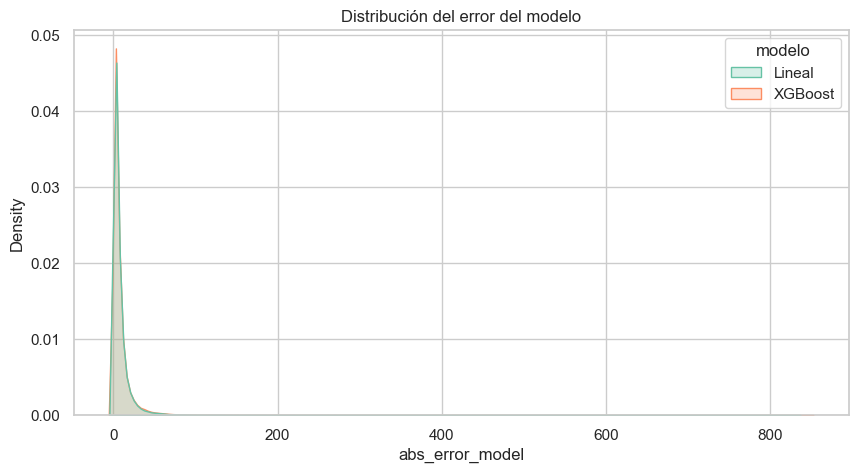

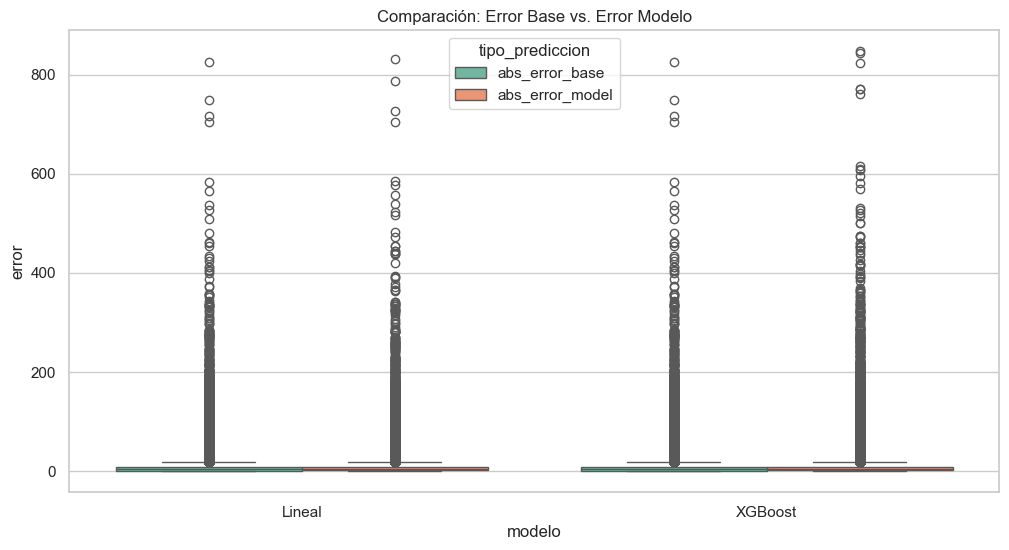

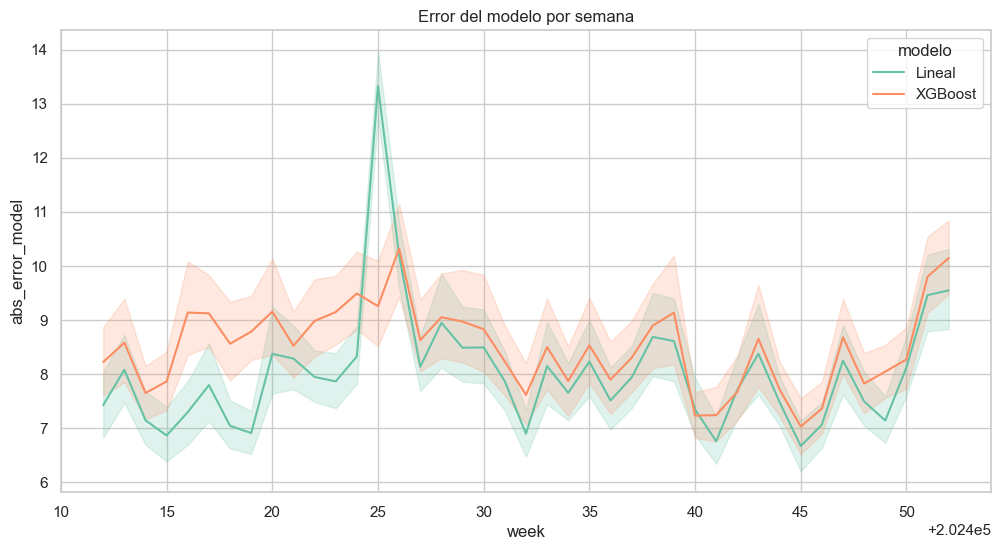

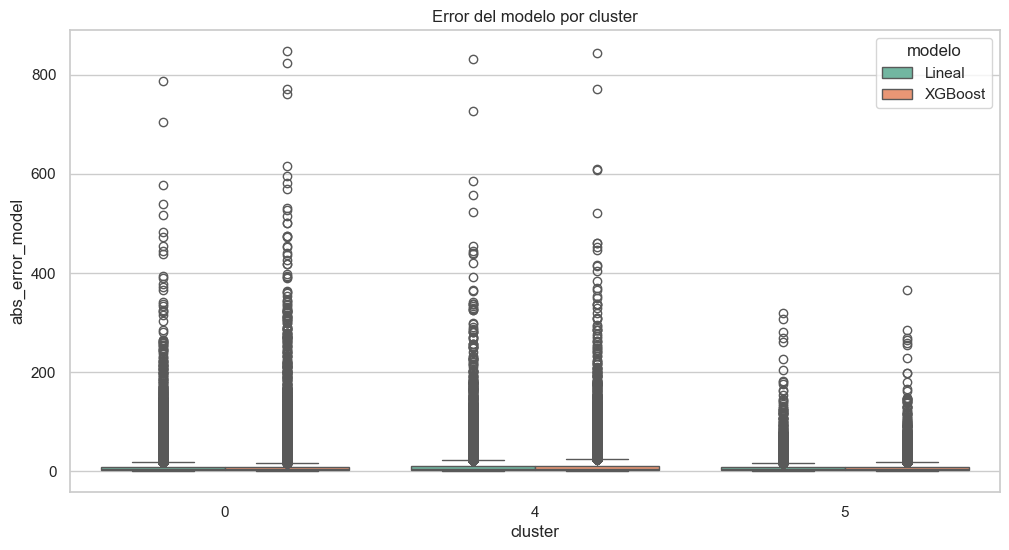

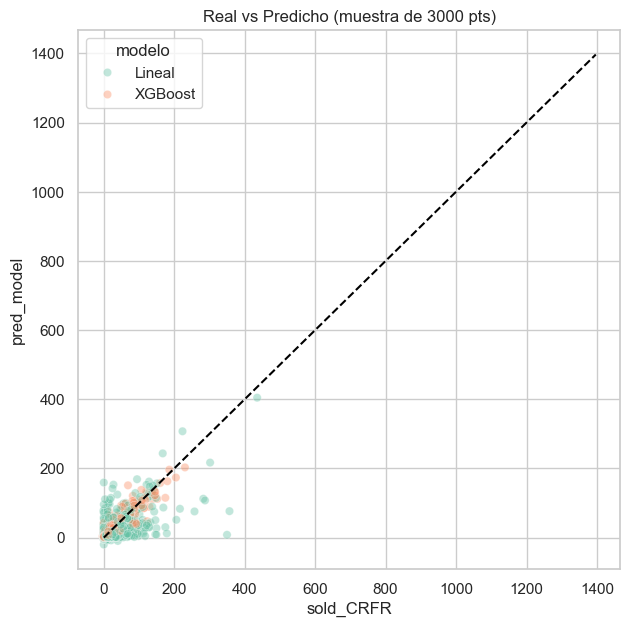

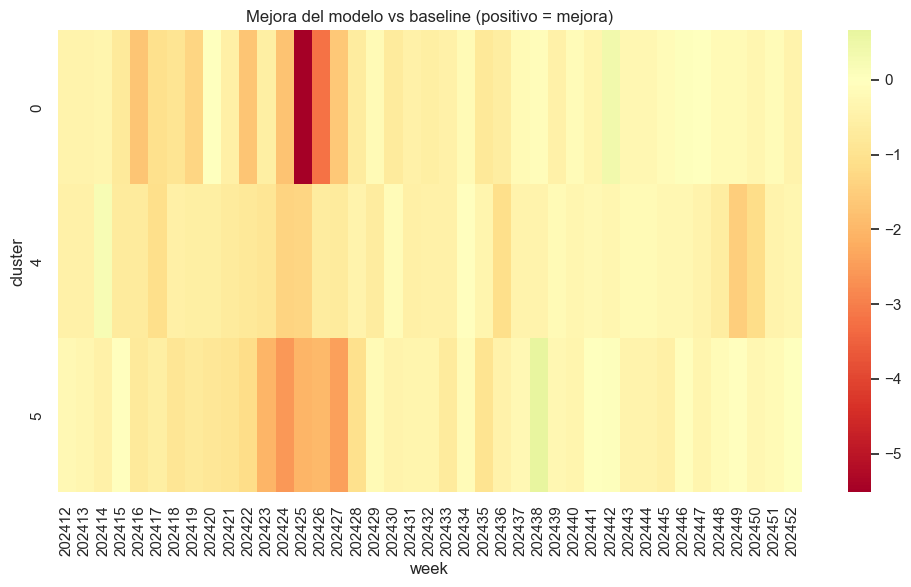

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##############################################
# 1. FUNCIÓN PARA UNIFICAR RESULTADOS
##############################################

def preparar_resultados(df, modelo_nombre, producto):
    df = df.copy()
    df["modelo"] = modelo_nombre
    df["producto"] = producto
    df["mejora_vs_base"] = df["abs_error_base"] - df["abs_error_model"]
    return df


##############################################
# 2. UNIFICAR LOS 4 DATASETS EN UN SOLO DF
##############################################

df_all = pd.concat([
    preparar_resultados(lineal_CRFR, "Lineal",  "CRFR"),
    preparar_resultados(lineal_CRFNR, "Lineal",  "CRFNR"),
    preparar_resultados(xgb_CRFR,     "XGBoost", "CRFR"),
    preparar_resultados(xgb_CRFNR,    "XGBoost", "CRFNR"),
], ignore_index=True)


##############################################
# 3. RESÚMENES ESTADÍSTICOS ÚTILES
##############################################

# Resumen global
resumen_global = df_all.groupby("modelo")[["abs_error_base","abs_error_model","mejora_vs_base"]].mean()
print("\n### ERROR PROMEDIO POR MODELO (GLOBAL)\n")
print(resumen_global)

# Resumen por producto
resumen_producto = df_all.groupby(["producto","modelo"])[["abs_error_base","abs_error_model","mejora_vs_base"]].mean()
print("\n### ERROR PROMEDIO POR PRODUCTO Y MODELO\n")
print(resumen_producto)

# Resumen por cluster
resumen_cluster = df_all.groupby(["cluster","modelo"])[["abs_error_base","abs_error_model","mejora_vs_base"]].mean()
print("\n### ERROR PROMEDIO POR CLUSTER\n")
print(resumen_cluster.head())

# Resumen por semana
resumen_week = df_all.groupby(["week","modelo"])[["abs_error_base","abs_error_model"]].mean()
print("\n### ERROR PROMEDIO POR SEMANA\n")
print(resumen_week.head())


##############################################
# 4. VISUALIZACIONES
##############################################

sns.set(style="whitegrid", palette="Set2")

###########################
# A. Distribución de errores
###########################
plt.figure(figsize=(10,5))
sns.kdeplot(data=df_all, x="abs_error_model", hue="modelo", fill=True)
plt.title("Distribución del error del modelo")
plt.show()

###########################
# B. Boxplot error vs baseline
###########################
plt.figure(figsize=(12,6))
df_plot = df_all.melt(
    id_vars=["modelo"],
    value_vars=["abs_error_base","abs_error_model"],
    var_name="tipo_prediccion",
    value_name="error"
)

sns.boxplot(data=df_plot, x="modelo", y="error", hue="tipo_prediccion")
plt.title("Comparación: Error Base vs. Error Modelo")
plt.show()



###########################
# D. Error por cluster (boxplot)
###########################
plt.figure(figsize=(12,6))
sns.boxplot(data=df_all, x="cluster", y="abs_error_model", hue="modelo")
plt.title("Error del modelo por cluster")
plt.show()

###########################
# E. Real vs Predicho (scatter)
###########################
plt.figure(figsize=(7,7))
sns.scatterplot(data=df_all.sample(3000, random_state=1), 
                x="sold_CRFR", y="pred_model", hue="modelo", alpha=0.4)
plt.title("Real vs Predicho (muestra de 3000 pts)")
plt.plot([0, df_all["sold_CRFR"].max()], [0, df_all["sold_CRFR"].max()], "k--")
plt.show()


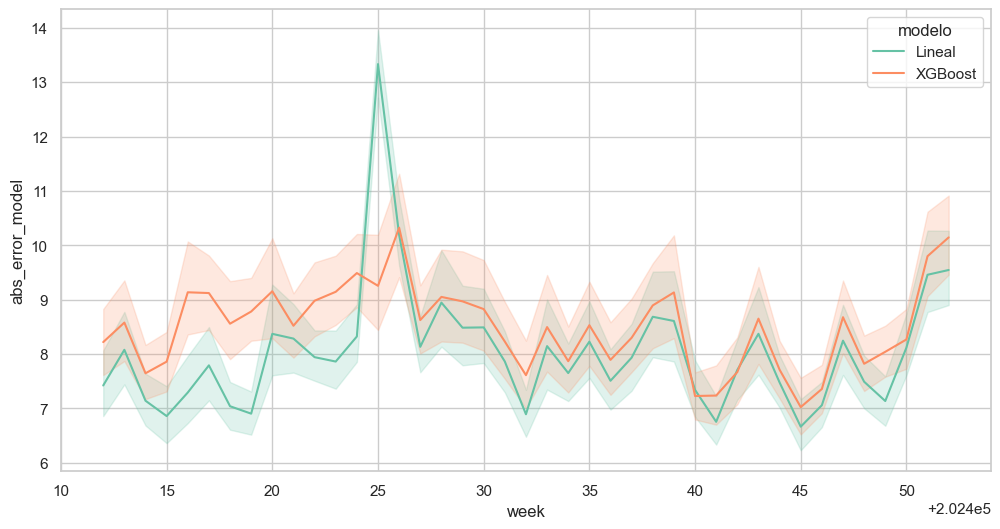

In [50]:
###########################
# C. Error por semana (curva)
###########################
plt.figure(figsize=(12,6))
sns.lineplot(data=df_all, x="week", y="abs_error_model", hue="modelo")
plt.show()

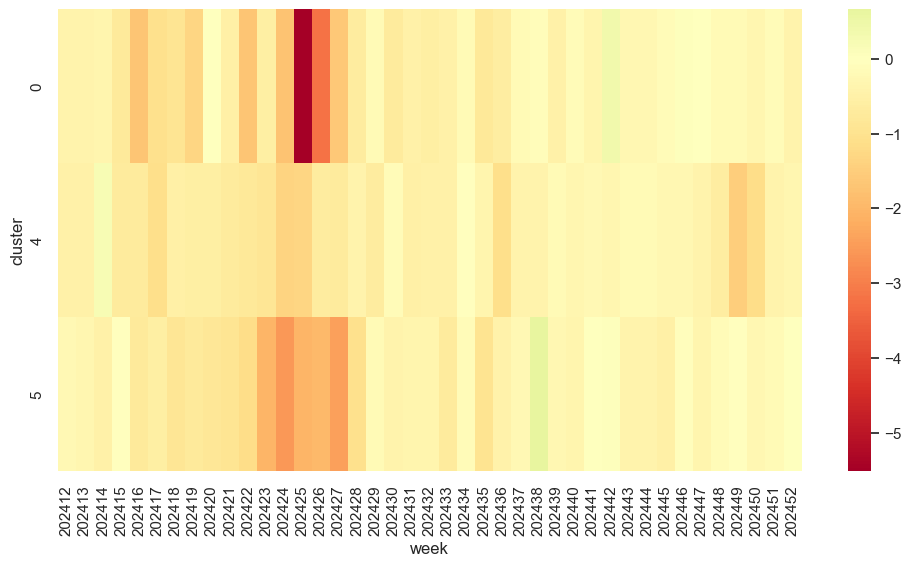

In [53]:
###########################
# F. Heatmap de MEJORA por cluster y semana
###########################
heat_df = df_all.groupby(["cluster","week"])["mejora_vs_base"].mean().unstack()

plt.figure(figsize=(12,6))
sns.heatmap(heat_df, cmap="RdYlGn", center=0)
plt.show()

In [52]:
df_all

,customer_id,weather_station_id,week,cluster,temp_mean_week,temp_std_week,temp_max_week,temp_min_week,temp_range_mean,days_above_30,...,lag2,lag3,pred_model,abs_error_model,abs_error_base,fold,modelo,producto,mejora_vs_base,pred_base
0,268cc3995edb5cd780663640ed121ae69ef56d49369670...,fd15fbdb96badcc3a102ee0c538601adbe23dfe42511f8...,202412,0,19.166667,0.680414,28.425926,10.555556,17.870370,0.0,...,35.58,41.56,43.937187,4.137187,2.29,0.0,Lineal,CRFR,-1.847187,NaN
1,26c2673a6b41873a8789129e0a753192a81a31337280f6...,004784ca59d476279540ee2fb4f01b1521c38a3cd643cc...,202412,0,21.944444,0.582672,31.574074,11.759259,19.814815,6.0,...,23.25,19.37,24.131948,13.561948,11.80,0.0,Lineal,CRFR,-1.761948,NaN
2,26ddef6ee22b3148cd8e314833901537ccff26b69aa13e...,694278a0d7919878b55f79d5ffc32517621cbc29c96a17...,202412,0,18.703704,1.434438,27.685185,11.018519,16.666667,0.0,...,41.92,41.56,44.056850,10.543150,13.56,0.0,Lineal,CRFR,3.016850,NaN
3,26fc12f169ded3c1fe232a61c5aecdea7ac0f33348fdfc...,ab1a0c25e39afe3a7199859e7ed34780f17691e0e363ee...,202412,0,16.296296,0.907218,27.129630,6.018519,21.111111,0.0,...,25.98,23.60,27.986577,0.866577,0.00,0.0,Lineal,CRFR,-0.866577,NaN
4,275f5f9b635ab56931054a92407d2ff85bcfcbe4549dd0...,004784ca59d476279540ee2fb4f01b1521c38a3cd643cc...,202412,0,21.944444,0.582672,31.574074,11.759259,19.814815,6.0,...,13.74,24.57,20.131871,15.448129,17.79,0.0,Lineal,CRFR,2.341871,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234835,00b9021f1bff2ea5f5de6a3c676b77441b95971c7af2fe...,NaN,202452,5,18.796296,0.226805,25.740741,12.870370,NaN,NaN,...,18.14,41.92,22.904863,22.904863,35.05,5.0,XGBoost,CRFNR,12.145137,35.05
234836,f1c89437ef09e4e1f3a0c0006cc34df398b4700d5cd257...,NaN,202452,5,18.611111,1.438020,23.888889,13.981481,NaN,NaN,...,7.04,7.75,7.008969,12.011031,11.98,5.0,XGBoost,CRFNR,-0.031031,7.04
234837,006a0380c0d745c36f9a282779e2a83b53b8bd14ecb18b...,NaN,202452,5,18.888889,0.860663,28.240741,11.666667,NaN,NaN,...,29.94,23.60,21.302839,24.137161,23.07,5.0,XGBoost,CRFNR,-1.067161,22.37
234838,f3c701db0a8deaf52cd176cd2f65441fa7a24960529dfc...,NaN,202452,5,18.888889,0.860663,28.240741,11.666667,NaN,NaN,...,6.34,17.61,11.233563,4.893563,3.17,5.0,XGBoost,CRFNR,-1.723563,9.51


In [43]:
resumen_week.to_clipboard()

In [44]:
resumen_global.to_clipboard()

In [46]:
resumen_producto.to_clipboard()

In [49]:
resumen_cluster.to_clipboard()